# Caret - R

1. Define Model
2. Define tuning parameter components
3. Define resampling method
4. Choose optimal based on performance

## Data Split

in <- createdDataPartition(data,p=.75)

training <- df[in,]
test <- df[-in,]

## Train Control

trainControl function allows resampling methods to be used to train models. Such as: "boot", "cv", "LOOCV", "LGOCV", "repeatedcv", "timeslice", "none" and "oob". repeatedcv peforms cv multiple times, averaging the results.

Can also use custom peformance summary method via __summaryFunction__.

summaryFunction = twoClassSummary, allows using metrics: sensitivity,specificty and ROC.

__selectionFunction__: Function to determine final model parameters.

__tolerance__: Function used to results with a chosen perc.


## Pre process

Pre process class allows operations on predictors including centering and scaling. Can be interfaced through the train method.

It centers and scales a variable to mean 0 and standard deviation 1. It ensures that the criterion for finding linear combinations of the predictors is based on how much variation they explain and therefore improves the numerical stability.

## TuneGrid

Can take a dataframe with each col the tuning parameter of the method, the values being the values to use. Use the function expand.grid(par = c(), par2 = val). Param tuneGrid in train func.

__tuneLength__ (Another train param):an integer denoting the number of levels for each tuning parameter (ie if there are 2 parameters, tuneLength of 20 = 400 models tested) that should be generated by createGrid. (NOTE: If wanted, this argument must be named.)

## Plotting

plot(fit) Shows the results against the different parameter values.

bwolot() #box whisker
dotplot()
xyplot()
splot() #Scatter plot

## Predict

The predict function has two types class and prob.

## Model Comparison/ Performance

confusionMatrix()
postResample() #Defualt method
twoClassSummary() #ROC
prSummary() #AUC 
mnLogLoss() #Multi class multinominal log liklehood


Lift Curve - TBD
Calibration curve - TBD

### Confusion Matrix

Will produce a confusion matrix with accuracy, kappa and F-measure.

In [ ]:
confusionMatrix(pred,truth,mode='everything') #Binary class use.

## Feature Filter / Regularisation

### Univarite Filters

Use stats to compare peformance with different predictors.

sbf(predictors, outcome, sbfControl = sbfControl(),...)

Uses __anova Score__ for each predictors (use multivariate to combine predictors). The mean predictor values are equal across the two classes.

ctrl <- sbfControl(functions = rfSBF, method = "repeatedcv", repeats =5)

## Recursive Feature Elimination

Default: The predictors are ranked then the model is fit for progressively less bottom ranked predictors. Optional to recaulate predictor ranking at every stage.

Beaware of the pitfalls of overfitting using a single training set.

Can choose elimination method, algo 1 : No resampling __refIter()__ and algo 2 : Resampling __rfe()__ . 

__size__ : Param for subset sizes of predictors to be tested

rfeControl$functions needs to be defined based on type of model. 

# Parallel Processing

A separate function is used to “register” the parallel processing technique and specify the number of workers to use. There are a few packages related to **foreach** that can be used. Simply register the number of workers then run the code normally:

In [ ]:
library(doParallel)
cl <- makePSOCKcluster(5)
registerDoParallel(cl)

## All subsequent models are then run in parallel
model <- train(y ~ ., data = training, method = "rf")

## When you are done:
stopCluster(cl)

Can also set the **allowParallel** param to FALSE to not use any registered clusters.

## Submodels

Using a single trained model to produce predictions for multiple tuning parameters. (NOT AVAILABLE FOR SVM)

## Arbitary Model

If the list for rfeContol is not found one has to be created:

In [ ]:
# A simple list example for random forests:

rfRFE <-  list(summary = defaultSummary,
               fit = function(x, y, first, last, ...){
                 library(randomForest)
                 randomForest(x, y, importance = first, ...)
                 },
               pred = function(object, x)  predict(object, x),
               rank = function(object, x, y) {
                 vimp <- varImp(object)
                 vimp <- vimp[order(vimp$Overall,decreasing = TRUE),,drop = FALSE]
                 vimp$var <- rownames(vimp)                  
                 vimp
                 },
               selectSize = pickSizeBest,
               selectVar = pickVars)

# Recipes

In place of x,y formula can use recipes for a wider more customisable set of pre processing and validation tools.

List of uses for recipes:

- Convert qualitative predictor to indicator variable
- Transform data to diff scale
- Extract key features from raw vars

Possible step areas:

- Impute (ie sub missing values with mean)
- Individual transform (ie log)
- Discretisation (Convert cont to discrete)
- Dummy variables and encoding (ie create dummy var)
- Predictor interactions
- Normalisation (ie center)
- Multivariate Transformation (ie PCA)
- Filters (ie highly correlated)
- Row operation (ie sort)
- Others (ie rename)
- Check (ie check for missing)

Use tidy to force implement step.

## GLM Example

In [17]:
library(tidymodels)      # for the recipes package, along with the rest of tidymodels

# Helper packages
library(nycflights13)    # for flight data
library(skimr)           # for variable summaries

── Attaching packages ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidymodels 1.1.0 ──

✔ broom        1.0.4     ✔ tibble       3.2.1
✔ dials        1.2.0     ✔ tidyr        1.3.0
✔ infer        1.0.4     ✔ tune         1.1.1
✔ modeldata    1.1.0     ✔ workflows    1.1.3
✔ parsnip      1.1.0     ✔ workflowsets 1.0.1
✔ purrr        1.0.1     ✔ yardstick    1.2.0
✔ rsample      1.1.1     

── Conflicts ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidymodels_conflicts() ──
✖ purrr::discard()         masks scales::discard()
✖ dplyr::filter()          masks stats::filter()
✖ dplyr::lag()             masks stats::lag()
✖ purrr::lift()            masks caret::lift()
✖ yardstick::precision()   masks caret::precision()
✖ yardstick::recall()      masks caret::recall()
✖ yardstick::sensitivity() masks caret::sens

In [18]:
set.seed(123)

flight_data <- 
  flights %>% 
 mutate(
    # Convert the arrival delay to a factor
    arr_delay = ifelse(arr_delay >= 30, "late", "on_time"), #change vals to strings
    arr_delay = factor(arr_delay),
    # We will use the date (not date-time) in the recipe below
    date = lubridate::as_date(time_hour) #lubridate is R package for dates
  ) %>% 
  # Only retain the specific columns we will use
  select(dep_time, flight, origin, dest, air_time, distance, 
         carrier, date, arr_delay, time_hour) %>% 
  # Exclude missing data
  na.omit() %>% 
  # For creating models, it is better to have qualitative columns
  # encoded as factors (instead of character strings)
  mutate_if(is.character, as.factor)

flight_data

dep_time,flight,origin,dest,air_time,distance,carrier,date,arr_delay,time_hour
<int>,<int>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<date>,<fct>,<dttm>
517,1545,EWR,IAH,227,1400,UA,2013-01-01,on_time,2013-01-01 05:00:00
533,1714,LGA,IAH,227,1416,UA,2013-01-01,on_time,2013-01-01 05:00:00
542,1141,JFK,MIA,160,1089,AA,2013-01-01,late,2013-01-01 05:00:00
544,725,JFK,BQN,183,1576,B6,2013-01-01,on_time,2013-01-01 05:00:00
554,461,LGA,ATL,116,762,DL,2013-01-01,on_time,2013-01-01 06:00:00
554,1696,EWR,ORD,150,719,UA,2013-01-01,on_time,2013-01-01 05:00:00
555,507,EWR,FLL,158,1065,B6,2013-01-01,on_time,2013-01-01 06:00:00
557,5708,LGA,IAD,53,229,EV,2013-01-01,on_time,2013-01-01 06:00:00
557,79,JFK,MCO,140,944,B6,2013-01-01,on_time,2013-01-01 06:00:00


In [19]:
flight_data %>% 
  count(arr_delay) %>% 
  mutate(prop = n/sum(n)) #Creates table based on prev result 

arr_delay,n,prop
<fct>,<int>,<dbl>
late,52802,0.1613033
on_time,274544,0.8386967


Flight number and time_hour are identifiers and not wanted in model training.

In [20]:
flight_data %>% 
  skimr::skim(dest, carrier) 

── Data Summary ────────────────────────
                           Values    
Name                       Piped data
Number of rows             327346    
Number of columns          10        
_______________________              
Column type frequency:               
  factor                   2         
________________________             
Group variables            None      

── Variable type: factor ───────────────────────────────────────────────────────
  skim_variable n_missing complete_rate ordered n_unique
1 dest                  0             1 FALSE        104
2 carrier               0             1 FALSE         16
  top_counts                                    
1 ATL: 16837, ORD: 16566, LAX: 16026, BOS: 15022
2 UA: 57782, B6: 54049, EV: 51108, DL: 47658    


Warning message in is.null(text_repr) || nchar(text_repr) == 0L:
“'length(x) = 7 > 1' in coercion to 'logical(1)'”


,skim_type,skim_variable,n_missing,complete_rate,factor.ordered,factor.n_unique,factor.top_counts
,<chr>,<chr>,<int>,<dbl>,<lgl>,<int>,<chr>
1,factor,dest,0,1,FALSE,104,"ATL: 16837, ORD: 16566, LAX: 16026, BOS: 15022"
2,factor,carrier,0,1,FALSE,16,"UA: 57782, B6: 54049, EV: 51108, DL: 47658"


In [21]:
# Fix the random numbers by setting the seed 
# This enables the analysis to be reproducible when random numbers are used 
set.seed(222)
# Put .75 of the data into the training set 
data_split <- initial_split(flight_data, prop = .75)

# Create data frames for the two sets:
train_data <- training(data_split)
test_data  <- testing(data_split)

In [22]:
#Instead of the standard model formula with ~, use a recipe:

flights_rec <- 
  recipe(arr_delay ~ ., data = train_data) %>%
  update_role(flight, time_hour, new_role = "ID") %>% #Dont use these two preds in model only for identification
  step_date(date, features = c("dow", "month")) %>%  #create new preds and adds to df             
  step_holiday(date, 
               holidays = timeDate::listHolidays("US"), 
               keep_original_cols = FALSE) %>% #Adds holidays to df, removes data col
  step_dummy(all_nominal_predictors()) %>% #Creates dummy var using selector for all nominal vals
  step_zv(all_predictors()) #Removes constant dummy var


In [23]:
prep(flights_rec)



── Recipe ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:   1
predictor: 7
ID:        2



── Training information 

Training data contained 245509 data points and no incomplete rows.



── Operations 

• Date features from: date | Trained

• Holiday features from: date | Trained

• Dummy variables from: origin, dest, carrier, date_dow, date_month | Trained

• Zero variance filter removed: <none> | Trained



Recipes do not auto convert factors into dummy numeric values, needs to be done manually! In this case there is a dest value only in the test set not in the training set, so will be given a constant dummy var during training. To avoid this useless predictor step_zv() removes constant pred cols.

In [ ]:
#Use a model workflow to combine a model and recipe. (With caret can simply replace formula with recipe)

lr_mod <- 
  logistic_reg() %>% 
  set_engine("glm")

flights_wflow <- 
  workflow() %>% #Create workflow
  add_model(lr_mod) %>% 
  add_recipe(flights_rec)

flights_wflow

In [ ]:
flights_fit <- 
  flights_wflow %>% 
  fit(data = train_data)

#predict(flights_fit, test_data)

# RFE Example

In [7]:
library(caret)
library(mlbench)
library(Hmisc)
library(randomForest)


Attaching package: ‘Hmisc’


The following objects are masked from ‘package:dplyr’:

    src, summarize


The following objects are masked from ‘package:base’:

    format.pval, units


randomForest 4.7-1.1

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:dplyr’:

    combine


The following object is masked from ‘package:ggplot2’:

    margin




In [8]:
n <- 100
p <- 40
sigma <- 1
set.seed(1)
sim <- mlbench.friedman1(n, sd = sigma) #Produces a X matrix and Y Vector
colnames(sim$x) <- c(paste("real", 1:5, sep = ""), #Create col names real1,real2 etc
                     paste("bogus", 1:5, sep = ""))
bogus <- matrix(rnorm(n * p), nrow = n)

colnames(bogus) <- paste("bogus", 5+(1:ncol(bogus)), sep = "") #Create 45 noise values

x <- cbind(sim$x, bogus)
y <- sim$y

In [9]:
normalization <- preProcess(x) #Defualt pre process is to center and scale

x <- predict(normalization, x)
x <- as.data.frame(x)

subsets <- c(1:5, 10, 15, 20, 25)

In [10]:
set.seed(10)

# Set func for linear models, 10 k folds (number)
ctrl <- rfeControl(functions = lmFuncs,
                   method = "repeatedcv",
                   number = 10,
                   repeats = 10,
                   verbose = FALSE)

lmProfile <- rfe(x, y,
                 sizes = subsets,
                 rfeControl = ctrl)

lmProfile


Recursive feature selection

Outer resampling method: Cross-Validated (10 fold, repeated 10 times) 

Resampling performance over subset size:

 Variables  RMSE Rsquared   MAE RMSESD RsquaredSD  MAESD Selected
         1 3.957   0.3686 3.382 0.6071     0.1988 0.5660         
         2 3.520   0.5002 2.964 0.5456     0.1811 0.5276         
         3 3.112   0.6004 2.613 0.6046     0.1643 0.5359         
         4 2.839   0.6706 2.283 0.7707     0.1895 0.5459        *
         5 2.929   0.6556 2.337 0.7694     0.1827 0.5416         
        10 3.235   0.5924 2.604 0.8192     0.1921 0.5927         
        15 3.398   0.5697 2.707 0.8488     0.1998 0.6099         
        20 3.503   0.5552 2.805 0.8484     0.2018 0.6585         
        25 3.653   0.5352 2.942 0.8705     0.1982 0.6999         
        50 4.031   0.4782 3.249 0.8893     0.1956 0.7411         

The top 4 variables (out of 4):
   real4, real5, real2, real1


In [11]:
#Final model
lmProfile$fit


Call:
lm(formula = y ~ ., data = tmp)

Coefficients:
(Intercept)        real4        real5        real2        real1  
     14.613        2.857        1.965        1.625        1.359  


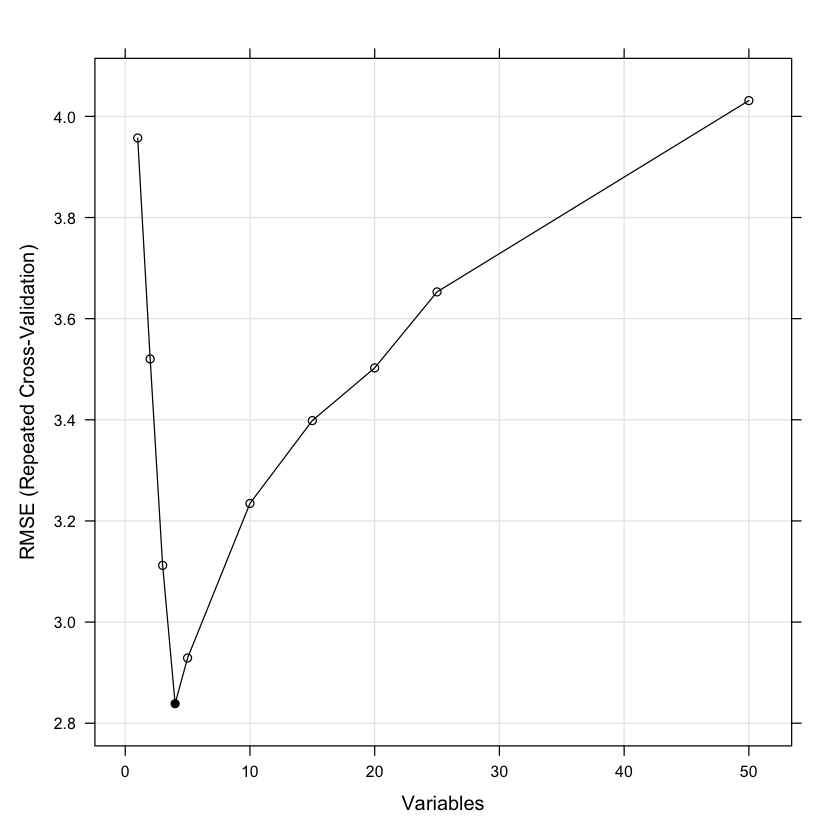

In [12]:
trellis.par.set(caretTheme())
plot(lmProfile, type = c("g", "o"))

In [ ]:
lmProfile$resample

In [ ]:
densityplot(lmProfile$resample)

# SVM Example

In [1]:
library(caret)
library(recipes)
library(dplyr)
library(QSARdata)

data(AquaticTox)
tox <- AquaticTox_moe2D
tox$Activity <- AquaticTox_Outcome$Activity
nrow(tox)

tox

Loading required package: ggplot2

Loading required package: lattice

Loading required package: dplyr


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘recipes’


The following object is masked from ‘package:stats’:

    step




[1] 322

Molecule,moeGao_Abra_L,moeGao_Abra_R,moeGao_Abra_acidity,moeGao_Abra_basicity,moeGao_Abra_pi,moe2D_BCUT_PEOE_0,moe2D_BCUT_PEOE_1,moe2D_BCUT_PEOE_2,moe2D_BCUT_PEOE_3,⋯,moe2D_vdw_vol,moe2D_vsa_acc,moe2D_vsa_don,moe2D_vsa_hyd,moe2D_vsa_other,moe2D_vsa_pol,moe2D_weinerPath,moe2D_weinerPol,moe2D_zagreb,Activity
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<dbl>
(d)-limonene,4.729,0.512,0.030,0.126,0.330,-2.696,-0.009128,0.04606,2.639,⋯,232.50,0.000,0,158.10,0.000,0.000,120,11,46,5.29
111-trichloro-2-methyl-2-propanolol(chlorobytanol),4.226,0.527,0.375,0.452,0.712,-2.556,-0.080280,0.05082,2.615,⋯,168.00,0.000,0,147.60,0.000,13.570,58,9,38,3.12
111-trichloroethane,2.790,0.383,0.030,0.101,0.469,-2.262,-0.083670,0.02702,2.350,⋯,110.60,0.000,0,118.20,0.000,0.000,16,0,20,3.40
1122-tetrachloroethane,3.636,0.496,0.168,0.078,0.577,-2.235,-0.101800,0.01105,2.377,⋯,126.60,0.000,0,118.30,13.660,0.000,29,4,22,3.92
112-trichloroethane,3.078,0.401,0.099,0.081,0.509,-2.260,-0.091020,0.03334,2.350,⋯,110.60,0.000,0,106.90,6.831,0.000,18,2,16,3.21
11-dichloroethylene(vinylidene,2.225,0.412,0.030,0.076,0.407,-1.806,-0.415800,0.40630,1.820,⋯,88.76,0.000,0,88.57,6.831,0.000,9,0,12,2.84
1234-tetrachlorobenzene,5.945,1.196,0.030,0.093,0.904,-2.089,-0.686300,0.65950,2.130,⋯,192.70,0.000,0,168.00,0.000,0.000,109,14,48,5.29
123-trichlorobenzene,5.228,1.061,0.030,0.131,0.852,-2.104,-0.680300,0.67320,2.116,⋯,176.70,0.000,0,149.70,0.000,0.000,82,11,42,4.89
123-trichloropropane,3.742,0.430,0.049,0.108,0.559,-2.422,-0.067810,0.04442,2.479,⋯,135.10,0.000,0,129.50,0.000,0.000,31,4,20,3.41


In [2]:
tox <- tox %>%
  select(-Molecule) %>%
  ## Suppose the easy of manufacturability is 
  ## related to the molecular weight of the compound
  mutate(manufacturability  = 1/moe2D_Weight) %>%
  mutate(manufacturability = manufacturability/sum(manufacturability))

In [3]:
#Function to calculate RMSE

model_stats <- function(data, lev = NULL, model = NULL) {
  
  stats <- defaultSummary(data, lev = lev, model = model)
  
  wt_rmse <- function (pred, obs, wts, na.rm = TRUE) 
  sqrt(weighted.mean((pred - obs)^2, wts, na.rm = na.rm))
  
  res <- wt_rmse(pred = data$pred,
                 obs = data$obs, 
                 wts = data$manufacturability)
  c(wRMSE = res, stats)
}

In [10]:
tox_recipe <- recipe(Activity ~ ., data = tox) %>%
#   add_role(manufacturability, new_role = "performance var") %>%
  step_nzv(all_predictors()) %>% #Remove sparse and unbalanced preds
  #Reduce dimension of vsa cols into surf_area.. cols
  step_pca(contains("VSA"), prefix = "surf_area_",  threshold = .95) %>%
  #Remove closely corr pred except from surf_area
  step_corr(all_predictors(), -starts_with("surf_area_"), threshold = .90) %>%
  # Center and scale
  step_center(all_predictors()) %>%
  step_scale(all_predictors())

In [12]:
tox_ctrl <- trainControl(method = "cv")
set.seed(888)
# tox_svm <- train(x, y,
#                  method = "svmRadial", 
#                  metric = "wRMSE",
#                  maximize = FALSE,
#                  tuneLength = 10,
#                  trControl = tox_ctrl,
#                 tuneGrid = expand.grid(C=seq(10,20,length=10),sigma=0.01150696))

# tox_svm

caretFuncs$fit <- function(x,y,first,last,...) train(x, y,
                 method = "svmRadial",
                 trControl = tox_ctrl,
                tuneGrid = expand.grid(C=12,sigma=0.01150696))


ctrl <- rfeControl(functions = caretFuncs,
                   method = "repeatedcv",
                   repeats = 5,
                   verbose = FALSE)

svmProfile <- rfe(tox_recipe,
                  data = tox,
                 sizes = c(2,10,15),
                 rfeControl = ctrl)

svmProfile

ERROR: Error in {: task 1 failed - "Metric Kappa not applicable for regression models"
